# T-Maze

Experiments with modifications to the t-maze enviroment.

see https://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf

In [17]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import random
import matplotlib.pyplot as plt
import numpy as np

In [31]:
class TMaze:   
    
    def __init__(self, size=3):
        self.size = size #takes size number of steps to reach decision node
    
    def __str__(self):
        statement = "Position: {}, Size: {}, Goal: {} ".format(self.position, self.size, self.getGoal(self.goal)) 
        return statement
                
    def getGoal(self, num):
        if num == 1:
            return "E"
        else:
            return "W"
        
    def step(self, action):
        """
        action - [0,1,2,3]
        directions = ["N","S","E","W"]
        Returns observation and reward
        """
        dx,dy = self.getDis(action)
        
        reward = 0
        done = False
        
        self.position += dy
        
        #going beyond maze upwards
        if self.position > self.size:
            reward = -0.1
            self.position += -1
        #downwards
        elif self.position < 0:
            reward = -0.1
            self.position += 1
            
        #moving left or right    
        if dx != 0:
            if self.position == self.size:
                if dx == self.goal:
                    reward = 4
                else:
                    reward = -0.1
                self.reset()
                done = True
            else:
                reward = -0.1
        
        return self.getObs(self.position),reward, done    
            
        
    def getObs(self, position):
        if position == 0:
            return self.observations[0]
        elif position == self.size:
            return self.observations[2]
        else:
            return self.observations[1]
    
    def getDis(self, action):
        """
        returns dx and dy, that represent change in position 
        """
        dis = [(0,1), (0,-1), (1,0), (-1,0)]
        return dis[action]
    
    def getAction(self, action):
        """
        for abstraction
        """
        directions = ["N","S","E","W"]
        return directions[action]
    
    def reset(self):
        
        """ Resets and returns initial observation """
        self.position = 0
        goal = random.choice([1,-1])
        self.goal = goal # 1 = 'E' -1 = 'W'        
        #'110' is W ;011 is E, corridor, decision node
        if goal == 1:
            self.observations = [(0,1,1),(1,0,1), (0,1,0)]
        else:
            self.observations = [(1,1,0),(1,0,1), (0,1,0)]
        return self.getObs(0)
    

In [32]:
env = TMaze() #size 3
print(env.reset())

print(env)

print(env.step(1))
print(env.step(2))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))

(1, 1, 0)
Position: 0, Size: 3, Goal: W 
((1, 1, 0), -0.1, False)
((1, 1, 0), -0.1, False)
((1, 0, 1), 0, False)
((1, 0, 1), 0, False)
((0, 1, 0), 0, False)
((0, 1, 0), -0.1, False)
((1, 1, 0), -0.1, True)


In [33]:
print(env)

Position: 0, Size: 3, Goal: W 


In [34]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def act(self, obs,reward, done):
        return random.choice([0,1,2,3])

In [35]:
randAgent = RandomAgent()
env = TMaze()
obs = env.reset()

done = False
reward = 0
totalRewards = []
episodes = 100
totalSteps = []
for i in range(episodes):
    cumReward = 0
    for step in range(1000):
        action = randAgent.act(obs,reward, done)
        obs,reward,done = env.step(action)
        cumReward += reward
        if done:
            break
    totalSteps.append(step)
    totalRewards.append(cumReward)
    #print("CumReward: {}, Steps: {}, Episode: {} ".format(cumReward, step, i)) 


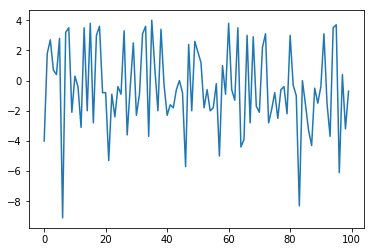

In [36]:
plt.plot(range(episodes), totalRewards)
plt.show()

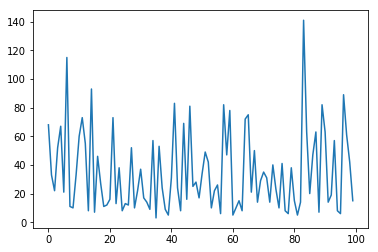

In [38]:
plt.plot(range(episodes), totalSteps)
plt.show()

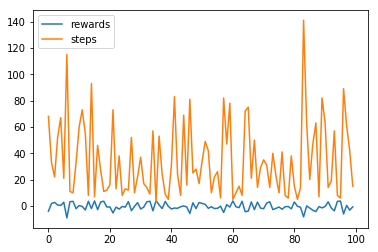

In [39]:
plt.plot(range(episodes), totalRewards, label = "rewards")
plt.plot(range(episodes), totalSteps, label = 'steps')
plt.legend()
plt.show()

# LSTM Agent as per 

https://arxiv.org/pdf/1507.06527.pdf
    

In [102]:
# Our Fast / Slow model
class LSTM_Agent(nn.Module):
    
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)
        
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x):
                
        h = F.relu(self.hidden(x))        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        h = h.unsqueeze(0)
        memory_activations, (self.h_state, self.c_state) = self.lstm(h, (self.h_state, self.c_state))
        q_out = self.q(memory_activations)
        
        return q_out
    
    def act(self, observation):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if np.random.rand() < 0.1:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
        

In [103]:
# Hyper Parameters

GAMMA = 0.98

In [124]:
agent = LSTM_Agent(learning_rate=0.0001)
env = TMaze()

In [125]:

observation = env.reset()

done = False
reward = 0
totalRewards = []
episodes = 50000
totalSteps = []

for i in range(episodes):    
    cumReward = 0
    
    # clear agents memory
    agent.reset()
    
    # get first action for agent
    action, q_values = agent.act(observation)    
    
    max_steps = 1000
    
    if i % 1000 == 0 and i != 0:
        print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}".format(
                i, 
                np.mean(totalRewards[-100:]),
                np.mean(totalSteps[-100:])
        ))
    
    for step in range(max_steps):
        
        # get next action and state
                
        next_observation, reward, done = env.step(action)
        next_action, next_q_values = agent.act(next_observation)            
        
        # ------------------------------
        # calculate DQN Loss        
        
        # v is the estimated value of the next state 
        v = torch.max(next_q_values)
        
        # q is the estimated value of the current state / action pair
        q = q_values[action]                
        loss = ((reward + GAMMA * v.detach()) - q)**2        
        
        # apply update
        agent.optimizer.zero_grad()
        loss.backward(retain_graph=(not done) or (step == max_steps-1))
        agent.optimizer.step()
        
        # keep track of everything
        cumReward += reward
        
        observation = next_observation
        action = next_action
        q_values = next_q_values        
        
        if done:
            break            
            
    totalSteps.append(step)
    totalRewards.append(cumReward)
    

Episode: 1000, Recent reward average: 1.96 steps average: 3.45
Episode: 2000, Recent reward average: 1.60 steps average: 3.38
Episode: 3000, Recent reward average: 2.22 steps average: 3.41
Episode: 4000, Recent reward average: 1.85 steps average: 3.29
Episode: 5000, Recent reward average: 1.52 steps average: 3.38
Episode: 6000, Recent reward average: 1.81 steps average: 3.35
Episode: 7000, Recent reward average: 1.80 steps average: 3.61
Episode: 8000, Recent reward average: 1.69 steps average: 3.31


KeyboardInterrupt: 

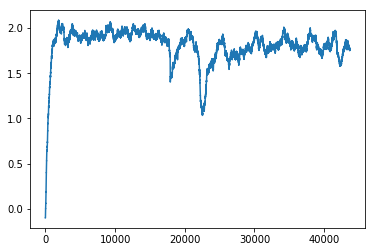

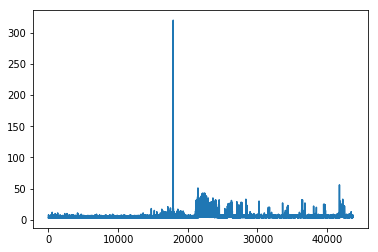

In [123]:
def smooth(X, gamma = 0.9):
    """ Returns exponential moving average. """
    y = X[0]
    out = []
    for x in X:
        y = gamma * y + (1-gamma) * x
        out.append(y)
    return out

plt.plot(range(len(totalRewards)), smooth(totalRewards,0.998), label = "rewards")
plt.show()
plt.plot(range(len(totalSteps)), totalSteps, label = 'steps')
plt.show()

In [101]:
print(np.mean(totalRewards[-100:]))

1.578
